In [ ]:
# Install library GIS dan AI
!pip install geopandas rasterio fiona shapely pyproj
!pip install scikit-learn pandas matplotlib seaborn
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data Curah Hujan Dan Hari Hujan Di DKI Jakarta Menurut Bulan.xlsx to Data Curah Hujan Dan Hari Hujan Di DKI Jakarta Menurut Bulan.xlsx
Saving Data Kejadian Bencana Banjir Tahun 2024.xlsx to Data Kejadian Bencana Banjir Tahun 2024.xlsx
Saving DEM SRTM 30M DKI JAKARTA.tfw to DEM SRTM 30M DKI JAKARTA.tfw
Saving DEM SRTM 30M DKI JAKARTA.tif to DEM SRTM 30M DKI JAKARTA.tif
Saving DEM SRTM 30M DKI JAKARTA.tif.aux.xml to DEM SRTM 30M DKI JAKARTA.tif.aux.xml
Saving DEM SRTM 30M DKI JAKARTA.tif.ovr to DEM SRTM 30M DKI JAKARTA.tif.ovr
Saving DEM SRTM 30M DKI JAKARTA.tif.ovr.aux.xml to DEM SRTM 30M DKI JAKARTA.tif.ovr.aux.xml
Saving DEM SRTM 30M DKI JAKARTA.tif.vat.cpg to DEM SRTM 30M DKI JAKARTA.tif.vat.cpg
Saving DEM SRTM 30M DKI JAKARTA.tif.vat.dbf to DEM SRTM 30M DKI JAKARTA.tif.vat.dbf
Saving Kecamatan DKI Jakarta.cpg to Kecamatan DKI Jakarta.cpg
Saving Kecamatan DKI Jakarta.dbf to Kecamatan DKI Jakarta.dbf
Saving Kecamatan DKI Jakarta.prj to Kecamatan DKI Jakarta.prj
Saving Kecamatan

In [ ]:
#Import Library
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Ubah nama sesuai file Anda
curah_hujan = pd.read_excel('Data Curah Hujan Dan Hari Hujan Di DKI Jakarta Menurut Bulan.xlsx')
banjir = pd.read_excel('Data Kejadian Bencana Banjir Tahun 2024.xlsx')
curah_hujan.head(), banjir.head()


(   tahun  bulan  curah_hujan  banyak_hari_hujan  periode_data
 0   2011      1        145.6               25.0          2011
 1   2011      2        230.7               18.0          2011
 2   2011      3        147.7               18.0          2011
 3   2011      4        106.8               16.0          2011
 4   2011      5        198.9               12.0          2011,
    periode_data  triwulan  bulan                  wilayah    kecamatan  \
 0        202406         2      6  KOTA ADM. JAKARTA UTARA  PENJARINGAN   
 1        202403         1      1  kota adm. jakarta barat   cengkareng   
 2        202403         1      1  kota adm. jakarta barat    kembangan   
 3        202403         1      1  kota adm. jakarta barat   kali deres   
 4        202403         1      1  kota adm. jakarta barat   cengkareng   
 
           kelurahan jumlah_rata_rata_ketinggian_air  jumlah_rw_terdampak  \
 0             PLUIT                    10 s.d 60 cm                    1   
 1  cengkareng 

Text(0.5, 1.0, 'Peta Kecamatan DKI Jakarta')

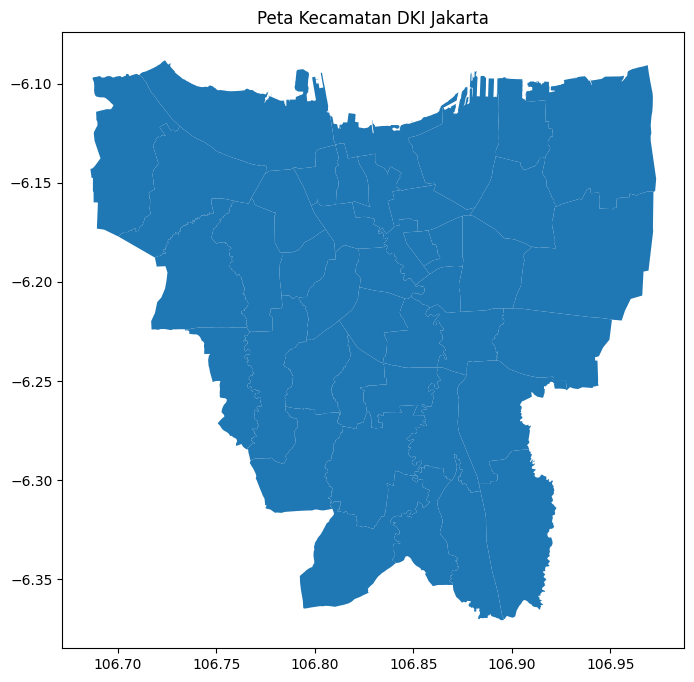

In [ ]:
kecamatan = gpd.read_file("Kecamatan DKI Jakarta.shp")
kecamatan = kecamatan.to_crs(epsg=4326)
kecamatan.plot(figsize=(10, 8))
plt.title("Peta Kecamatan DKI Jakarta")

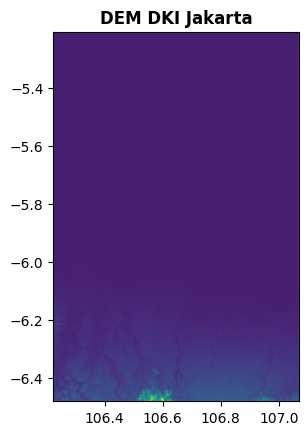

In [ ]:
dem_path = "DEM SRTM 30M DKI JAKARTA.tif"

with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    dem_meta = src.meta
    show(src, title="DEM DKI Jakarta")


In [ ]:
from rasterio.mask import mask
import json
from shapely.geometry import mapping

elevasi_per_kecamatan = []

with rasterio.open(dem_path) as src:
    for idx, row in kecamatan.iterrows():
        geom = [mapping(row['geometry'])]

        try:
            out_image, out_transform = mask(src, geom, crop=True)
            data = out_image[0]
            data = data[data != src.nodata]  # Buang nilai no-data
            rata2 = data.mean() if len(data) > 0 else np.nan
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            rata2 = np.nan

        elevasi_per_kecamatan.append(rata2)

kecamatan["elevasi_rata2"] = elevasi_per_kecamatan


kecamatan[["elevasi_rata2"]].head()




,elevasi_rata2
0,7.718837
1,48.416271
2,53.279634
3,17.078827
4,18.188717


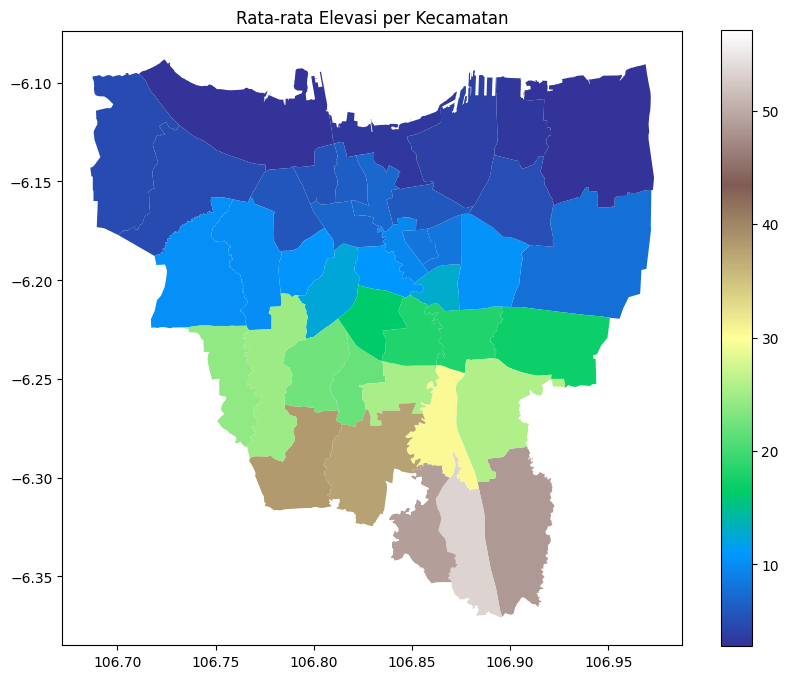

In [ ]:
kecamatan.plot(column="elevasi_rata2", cmap="terrain", legend=True, figsize=(10, 8))
plt.title("Rata-rata Elevasi per Kecamatan")
plt.show()


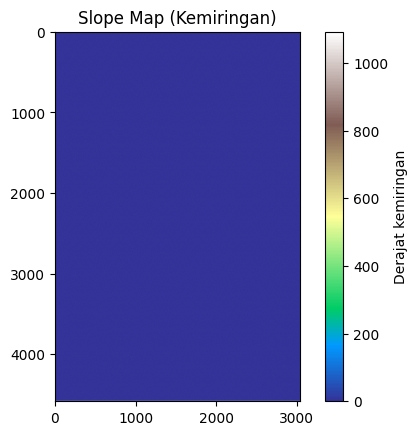

In [ ]:
from scipy import ndimage

# Hitung lereng dari DEM
def calculate_slope(dem_array, pixel_size=30):
    x, y = np.gradient(dem_array, pixel_size)
    slope = np.sqrt(x**2 + y**2)
    return slope

slope_data = calculate_slope(dem_data)
plt.imshow(slope_data, cmap="terrain")
plt.title("Slope Map (Kemiringan)")
plt.colorbar(label="Derajat kemiringan")
plt.show()


In [ ]:
# Standarkan nama kecamatan di data spasial dan data banjir
kecamatan["kecamatan"] = kecamatan["NAMOBJ"].str.strip().str.upper()
banjir["kecamatan"] = banjir["kecamatan"].str.strip().str.upper()

In [ ]:
# Agregasikan jumlah kejadian banjir per kecamatan
banjir_aggregated = banjir.groupby("kecamatan").agg({
    "jumlah_kejadian": "sum",
    "jumlah_rw_terdampak": "sum",
    "jumlah_kk_terdampak": "sum",
    "jumlah_jiwa_terdampak": "sum",
    "jumlah_korban_meninggal": "sum",
    "jumlah_korban_luka": "sum",
    "jumlah_pengungsi": "sum",
    "jumlah_tempat_pengungsian": "sum",
    "nilai_kerugian": "sum"
}).reset_index()

banjir_aggregated.head()


,kecamatan,jumlah_kejadian,jumlah_rw_terdampak,jumlah_kk_terdampak,jumlah_jiwa_terdampak,jumlah_korban_meninggal,jumlah_korban_luka,jumlah_pengungsi,jumlah_tempat_pengungsian,nilai_kerugian
0,CAKUNG,5,4,285,647,0,0,47,1,0
1,CENGKARENG,30,35,50,223,0,0,223,2,0
2,CILANDAK,16,17,28,84,0,0,0,0,0
3,CILINCING,16,8,144,488,0,0,120,2,0
4,CIPAYUNG,9,5,100,500,0,0,0,0,0


In [ ]:
# Gabungkan GeoDataFrame kecamatan dengan data banjir teragregasi
data_model = kecamatan.merge(banjir_aggregated, on="kecamatan", how="left")

# Isi nilai kosong (NaN) dengan 0 untuk kolom numerik (jika tidak semua kecamatan punya data banjir)
data_model.fillna(0, inplace=True)

data_model[["kecamatan", "elevasi_rata2", "jumlah_kejadian"]].head()


<ipython-input-42-e29004be5742>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_model.fillna(0, inplace=True)


,kecamatan,elevasi_rata2,jumlah_kejadian
0,CAKUNG,7.718837,5.0
1,CIPAYUNG,48.416271,9.0
2,CIRACAS,53.279634,6.0
3,DUREN SAWIT,17.078827,0.0
4,JATINEGARA,18.188717,45.0


In [ ]:
# Hitung rata-rata curah hujan per tahun
curah_tahunan = curah_hujan.groupby("tahun").agg({
    "curah_hujan": "mean",
    "banyak_hari_hujan": "mean"
}).reset_index()

curah_tahunan.head()


,tahun,curah_hujan,banyak_hari_hujan
0,2011,106.175000,12.750000
1,2012,130.866667,11.600000
2,2013,210.675000,15.500000
3,2014,242.333333,13.083333


In [ ]:
# Ambil data curah hujan tahun terakhir
data_curah_terakhir = curah_tahunan[curah_tahunan["tahun"] == curah_tahunan["tahun"].max()]

avg_curah = data_curah_terakhir["curah_hujan"].values[0]
avg_hari_hujan = data_curah_terakhir["banyak_hari_hujan"].values[0]


In [ ]:
# Tambahkan ke semua baris di GeoDataFrame sebagai fitur global
data_model["avg_curah_hujan"] = avg_curah
data_model["avg_hari_hujan"] = avg_hari_hujan
data_model[["kecamatan", "jumlah_kejadian", "avg_curah_hujan", "avg_hari_hujan"]].head()

,kecamatan,jumlah_kejadian,avg_curah_hujan,avg_hari_hujan
0,CAKUNG,5.0,242.333333,13.083333
1,CIPAYUNG,9.0,242.333333,13.083333
2,CIRACAS,6.0,242.333333,13.083333
3,DUREN SAWIT,0.0,242.333333,13.083333
4,JATINEGARA,45.0,242.333333,13.083333


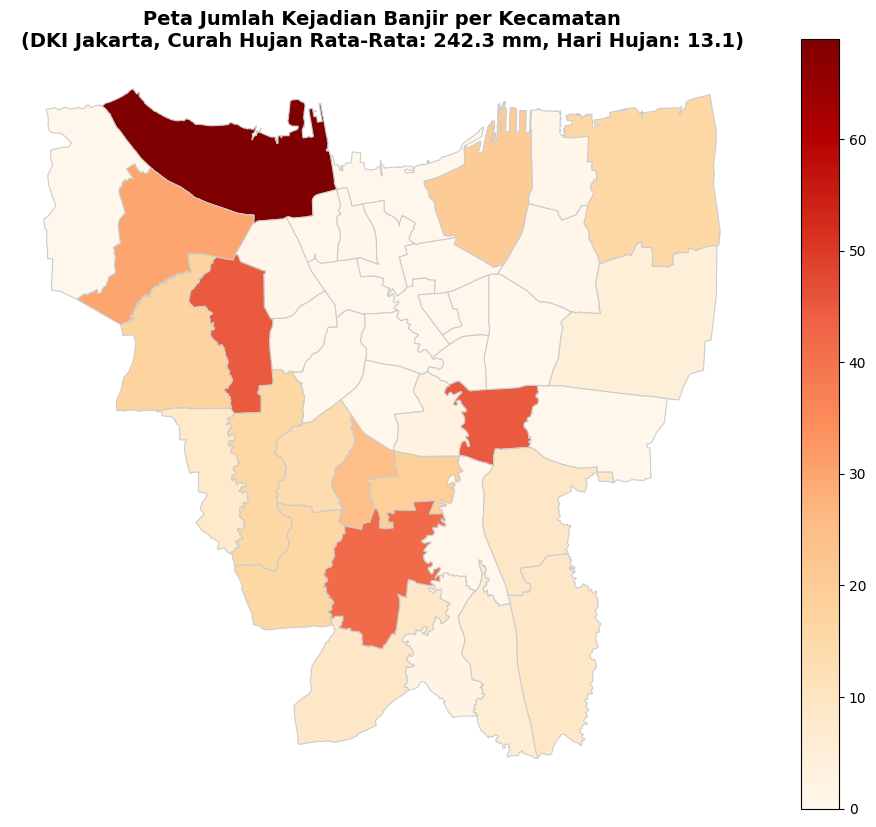

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

data_model.plot(column="jumlah_kejadian", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

avg_ch = round(data_model["avg_curah_hujan"].iloc[0], 1)
avg_hh = round(data_model["avg_hari_hujan"].iloc[0], 1)

ax.set_title(
    f"Peta Jumlah Kejadian Banjir per Kecamatan\n(DKI Jakarta, Curah Hujan Rata-Rata: {avg_ch} mm, Hari Hujan: {avg_hh})",
    fontsize=14,
    fontweight='bold'
)

ax.set_axis_off()

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
features = ["avg_curah_hujan", "avg_hari_hujan"]
if "elevasi_rata2" in data_model.columns:
    features.append("elevasi_rata2")

X = data_model[features]
y = data_model["jumlah_kejadian"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Fitur yang digunakan:\n", features)
print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


Fitur yang digunakan:
 ['avg_curah_hujan', 'avg_hari_hujan', 'elevasi_rata2']

X_train shape: (33, 3)
y_train shape: (33,)


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Inisialisasi model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Latih model
model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Evaluasi performa model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluasi Model Random Forest:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")


Evaluasi Model Random Forest:
MAE  : 10.18
RMSE : 16.26
R²   : -0.37


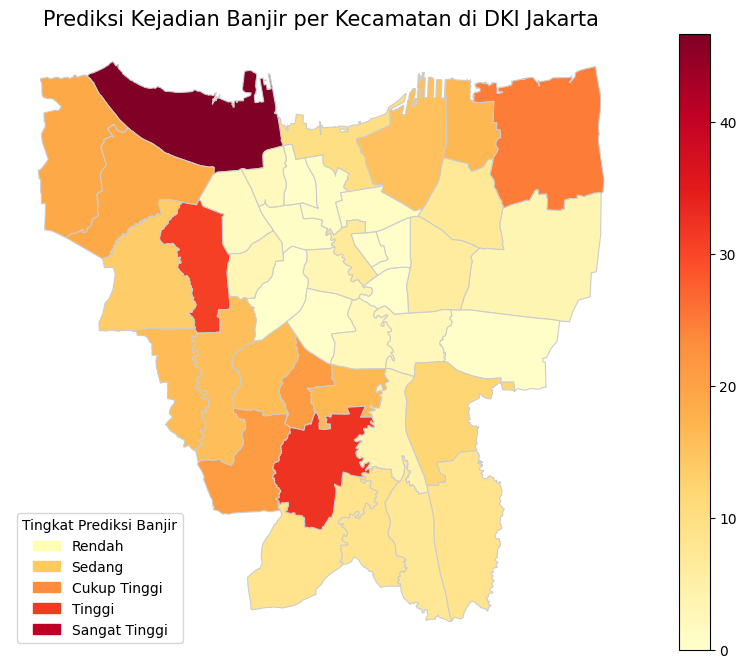

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Salin data_model agar tidak mengubah data asli
data_visual = data_model.copy()

# Prediksi jumlah kejadian banjir menggunakan seluruh data
data_visual["prediksi_kejadian"] = model.predict(data_visual[features])

# Buat figure dan axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot peta dengan kolom prediksi_kejadian
data_visual.plot(
    column="prediksi_kejadian",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True
)

# Judul dan styling
plt.title("Prediksi Kejadian Banjir per Kecamatan di DKI Jakarta", fontsize=15)
ax.axis("off")

# Penjelasan legenda warna manual
legend_patches = [
    mpatches.Patch(color="#ffffb2", label="Rendah"),
    mpatches.Patch(color="#fecc5c", label="Sedang"),
    mpatches.Patch(color="#fd8d3c", label="Cukup Tinggi"),
    mpatches.Patch(color="#f03b20", label="Tinggi"),
    mpatches.Patch(color="#bd0026", label="Sangat Tinggi")
]

# Tambahkan legenda kustom
plt.legend(handles=legend_patches, title="Tingkat Prediksi Banjir", loc="lower left")

# Tampilkan
plt.show()
